In [34]:
# basic imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else


from backtesting.trading_strategy import trade

from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from utils.helpers import _get_train_dev_frac


## workflow imports
from models.statistical_models import execute_kalman_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(execute_kalman_workflow)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###

### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

from utils.helpers import return_score
### HYPERPARAM OPTIMIZATION IMPORTS ###

In [4]:
return_datasets = True
verbose = True

In [5]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'delta': 0.014784091621725818, 'obs_cov_reg': 2.5600560664086465, 'trans_cov_avg': 0.09999999999999999, 'obs_cov_avg': 3.4796803986835676}

results_all_years = {}
outputs_all_years = {}
for end_year in [2020, 2021, 2022, 2023, 2024][:1]:
  ### Year-specific data ###
  startDateStr = '2008-01-01'
  endDateStr = f'{end_year}-12-31'
  startDateStrTest = f'{end_year}-01-01'
  endDateStrTest = f'{end_year}-12-31'
  train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  if pairs_data_filtered is None:
    scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
    pairs_data = {key:value[1]  for (key, value) in pairs.items()}
    pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
    pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
    save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  ### Year-specific data ###

  ### OPTIONAL: define worfklow here for debugging ###

  ### OPTIONAL: define worfklow here for debugging ###

  # Gather results for current_year
  results_kalman_current_year = []
  all_outputs_kalman_current_year = []
  num_results = min(len(pairs_data_filtered), 1)
  for i in tqdm(range(num_results), desc = "Gathering [...]"):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pair_tup_str_current = f"({ticker_a},{ticker_b})"
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
      gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
      output_model = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
      # print(output_model
      yoy_str = f"{output_model['yoy_mean'] * 100:.2f}% +- {output_model['yoy_std'] * 100:.2f}%"
      returns_score = return_score(output_model['yoy_mean'], gt_yoy)
      cointegration_score = pairs_data_filtered[i][1]
      results_kalman_current_year.append((pair_tup_str_current, cointegration_score, output_model['val_mse'], output_model['test_mse'], yoy_str, gt_yoy, returns_score)) # (pair, cointegration_score, val, test, yoy_str, gt_yoy, returns_score)
      all_outputs_kalman_current_year.append(output_model)
  results_all_years[end_year] = results_kalman_current_year
  outputs_all_years[end_year] = all_outputs_kalman_current_year

Gathering [...]:   0%|          | 0/1 [00:00<?, ?it/s]

Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 3.6243235576283928
Test MSE: 6.248608346968328
YOY Returns: 4.96%
YOY Std: +- 0.35%
GT Yoy: 65.74%
Plot filepath parent dir: data/results
pair_tup_str: (SHV,SMH)
  


# 1. Get the same gt yoy returns

In [ ]:
pairs_timeseries_df = output_model['pairs_timeseries']
look_back = 0
total_len = len(pairs_timeseries_df)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = pairs_timeseries_df.iloc[:train_size]
dev   = pairs_timeseries_df.iloc[train_size:train_size + dev_size]
test  = pairs_timeseries_df.iloc[train_size + dev_size:]

index_shortened = test.index[:len(test['Spread_Close'].values[look_back:])] # problem: test['S1_close'].iloc[look_back:] and testY_untr are the same.. So we should rather be using test
spread_gt_series = pd.Series(test['Spread_Close'].values[look_back:], index=index_shortened)
gt_returns_test = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_gt_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 3,
    clearing_threshold = 0.4
)
gt_yoy_test = ((gt_returns_test[-1] / gt_returns_test[0])**(252 / len(gt_returns_test)) - 1)

0.6573616080368379

# 2. Make all plots from PTDL notebook


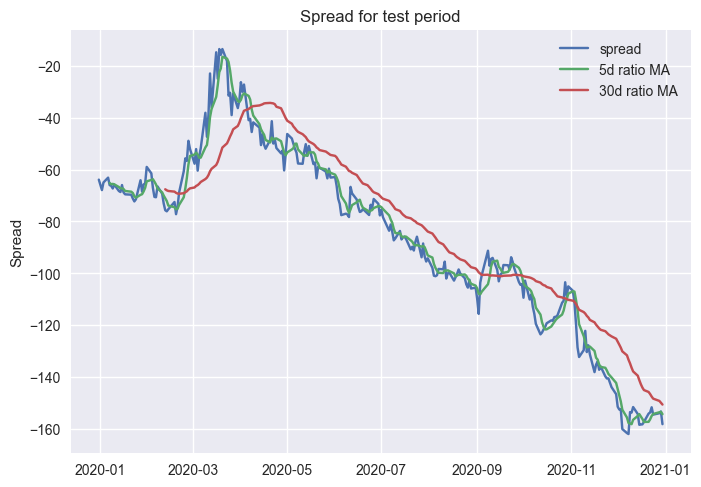

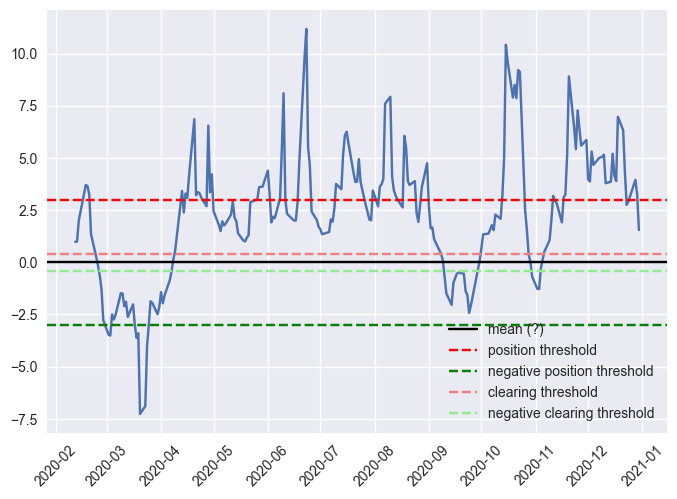

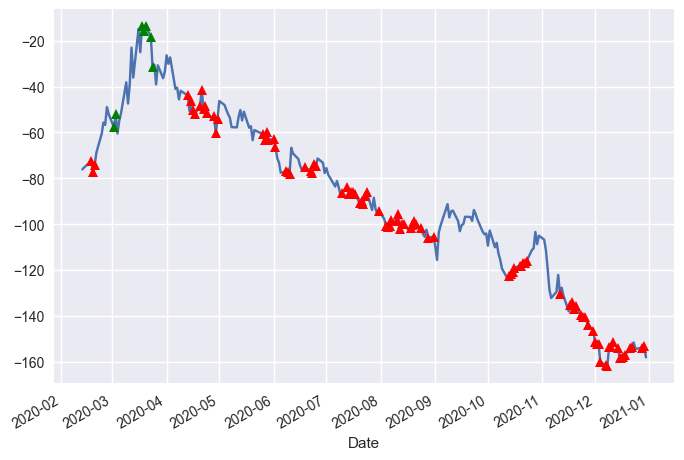

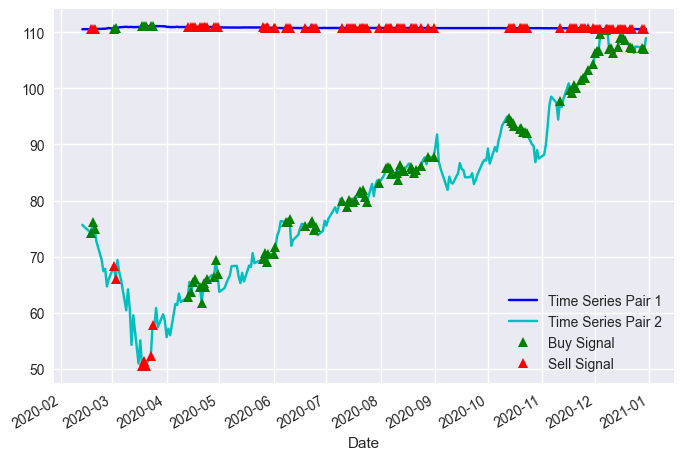

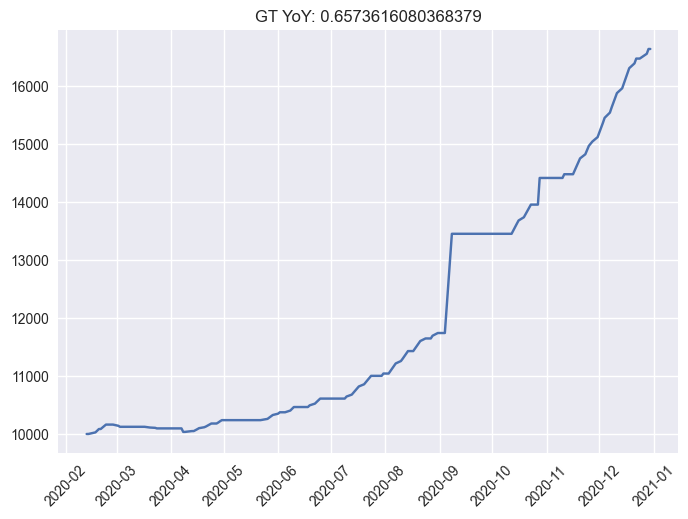

In [53]:
# 1. Visualizing Spreads
window_long = 30
window_short = 5

pairs_timeseries = pairs_timeseries_df
target_col = "Spread_Close"

test_univariate = pairs_timeseries.iloc[train_size + dev_size:][target_col]

ma_long = test_univariate.rolling(window=window_long, center=False).mean()
ma_short = test_univariate.rolling(window=window_short, center=False).mean()

plt.plot(test_univariate, label="spread")
plt.plot(ma_short, label="5d ratio MA")
plt.plot(ma_long, label="30d ratio MA")
plt.ylabel("Spread")
plt.title("Spread for test period")
plt.legend()
plt.show()

# 2. Visualizing z-score
position_threshold = 3.0
clearing_threshold = 0.4

std = test_univariate.rolling(window=window_short, center=False).std()
zscore = (ma_long - ma_short)/std

plt.plot(zscore)
plt.axhline(0, color='black', label='mean (?)')
plt.axhline(position_threshold, color='red', linestyle='--', label='position threshold')
plt.axhline(- position_threshold, color='green', linestyle='--', label="negative position threshold")
plt.axhline(clearing_threshold, color='lightcoral', linestyle='--', label='clearing threshold')
plt.axhline(- clearing_threshold, color='lightgreen', linestyle='--', label='negative clearing threshold')

plt.xticks(rotation=45)
plt.legend()
plt.show()

# 3. show signals wrt spread

test_univariate[window_long:].plot()

buy = test_univariate.copy()
sell = test_univariate.copy()
buy[zscore>-position_threshold] = np.nan 
sell[zscore<position_threshold] = np.nan
buy[window_long:].plot(color='g', linestyle='None', marker='^')
sell[window_long:].plot(color='r', linestyle='None', marker='^')
plt.show()

# 4. show signals wrt S1 and S2
test_multivariate = pairs_timeseries.iloc[train_size + dev_size:]

S1 = test_multivariate['S1_close']
S2 = test_multivariate['S2_close']

S1[window_long:].plot(color='b', label="Time Series Pair 1")
S2[window_long:].plot(color='c', label="Time Series Pair 2")
buyR = np.nan*S1.copy()
sellR = np.nan*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[pd.notna(buy)] = S1[pd.notna(buy)]
sellR[pd.notna(buy)] = S2[pd.notna(buy)]
# When selling the ratio, sell S1 and buy S2 
buyR[pd.notna(sell)] = S2[pd.notna(sell)]
sellR[pd.notna(sell)] = S1[pd.notna(sell)]

buyR[window_long:].plot(color='g', linestyle='None', marker='^', label='Buy Signal')
sellR[window_long:].plot(color='r', linestyle='None', marker='^', label="Sell Signal")

plt.legend()
plt.show()

# 5. plot the equity progression
spread = test_univariate

# Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
s2_spread = max(S2) - min(S2)
s1_spread = max(S1) - min(S1)
spread_spread = max(spread) - min(spread)
avg_spread = (s2_spread + s1_spread + spread_spread) / 3
initial_cash = avg_spread * len(spread) # the absolute returns are correlated to the length of the spread, times the average range.
# overwrite initial_cash to standard value
initial_cash = 10000

# Simulate trading
# Start with no money and no positions
cash = initial_cash # initial cash amount, perhaps not hardcoded in the future
qty_s1 = 0
qty_s2 = 0
returns = [initial_cash]

for i in range(len(spread)):
    # Sell short if the z-score is > 1
    if zscore.iloc[i] > position_threshold:
        # print(f"[NEW] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
        cash += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
        qty_s1 -= 1
        qty_s2 += spread.iloc[i]
    # Buy long if the z-score is < 1
    elif zscore.iloc[i] < -position_threshold:
        # print(f"[NEW] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
        cash -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
        qty_s1 += 1
        qty_s2 -= spread.iloc[i]
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscore.iloc[i]) < clearing_threshold:
        # print(f"[NEW] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
        cash += qty_s1 * S1.iloc[i] - S2.iloc[i] * qty_s2
        qty_s1 = 0
        qty_s2 = 0
    returns.append(cash) # append the current cash value to returns
# If at any point returns is 0, all values after that is zero
zero_from_this_idx = -1
for i in range(len(returns)):
    if returns[i] <= 0:
        zero_from_this_idx = i
        break
if zero_from_this_idx > -1:
    returns[zero_from_this_idx:] = [0] * (len(returns) - zero_from_this_idx)
    
# Shrink returns by a factor such that returns are not inflated (more explanation given in methodology).
returns_series = pd.Series(returns)
alpha = 0.005  # Shrinking/stretching factor
returns_uninflated = returns_series.copy()
mask_positive = returns_series > initial_cash
returns_uninflated[mask_positive] = initial_cash + alpha * (returns_series[mask_positive] - initial_cash)

beta = 0.005
mask_negative = (returns_series < initial_cash) & (returns_series > 0) # in case of total loss of equity, do not mask
returns_uninflated[mask_negative] = initial_cash - beta * (initial_cash - returns_series[mask_negative])

returns_uninflated = returns_uninflated.tolist()

returns_with_index = pd.Series(returns_uninflated[1:], index=test_univariate.index)

gt_yoy_test = ((returns_uninflated[-1] / returns_uninflated[0])**(252 / len(returns_uninflated)) - 1)
plt.title(f"GT YoY: {gt_yoy_test}")
plt.plot(returns_with_index[window_long:])
plt.xticks(rotation=45)
plt.show()

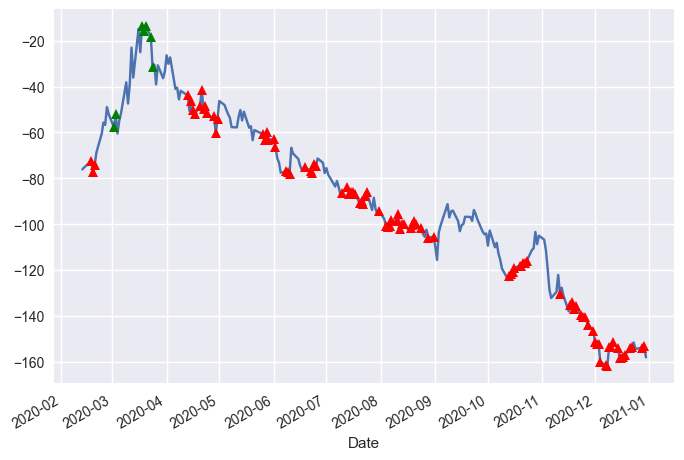

# 3. Do the same for predictions


# 4. Make all plots from PDTL notebook using predictions as well
might be better to create plotting functions for it